In [278]:
import pandas as pd
import numpy as np
from nltk.data import load
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
train_data = pd.read_csv("fallreports_2023-9-21_train.csv")
test_data = pd.read_csv("fallreports_2023-9-21_test.csv")

In [3]:
train_data

,record_id,redcap_repeat_instrument,gender,race,ethnicity,education,age_at_enrollment,pd_duration,num_falls_6_mo,previous_falls,...,location_binary,fall_description,fall_class,fog_yn,fall_desc_repeat,aime2023_dataset,last_followup,fall_total,fall_rate,category
0,66,Fall Report,Male,White,Not Hispanic or Latino,Completed college,60,2.4,NaN,non-faller,...,No,The patient was hiking. He tripped on an expos...,BoS (slips / trips),No,No,Yes,378,1,0.002646,train
1,28,Fall Report,Male,White,Not Hispanic or Latino,Completed college,56,8.0,3 or more,faller,...,Yes,The patient was reaching forward for his phone...,CoM (self-induced or externally-applied),No,No,No,402,231,0.574627,train
2,57,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,69,2.7,NaN,non-faller,...,No,The patient was digging a hole to plant an aza...,BoS (slips / trips),No,No,Yes,394,8,0.020305,train
3,39,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,76,9.7,3 or more,faller,...,Yes,The patient was walking towards the kitchen ta...,CoM (self-induced or externally-applied),No,No,Yes,96,480,5.000000,train
4,55,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,56,9.8,1,faller,...,No,The patient was home playing catch in backyard...,"Unclassifiable (falls from bed, sports-related...",No,No,Yes,391,2,0.005115,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,16,Fall Report,Female,White,Not Hispanic or Latino,Completed high school,64,7.9,3 or more,faller,...,Yes,The patient was in the living room trying to s...,CoM (self-induced or externally-applied),No,No,Yes,371,12,0.032345,train
295,122,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,65,7.1,1,faller,...,No,The patient was at the supermarket. He took on...,CoM (self-induced or externally-applied),No,No,Yes,383,8,0.020888,train
296,39,Fall Report,Male,White,Not Hispanic or Latino,Completed graduate degree,76,9.7,3 or more,faller,...,Yes,The patient was walking to the kitchen counter...,CoM (self-induced or externally-applied),No,No,Yes,96,480,5.000000,train
297,56,Fall Report,Female,White,Not Hispanic or Latino,"Completed junior college (associate's degree, ...",65,15.7,3 or more,faller,...,Yes,The patient was in their bathroom and there wa...,BoS (slips / trips),No,No,No,380,37,0.097368,train


In [4]:
np.unique(train_data["previous_falls"], return_counts=True)

(array(['faller', 'non-faller'], dtype=object), array([279,  20]))

In [5]:
X_train = train_data.drop(["fog_q_class", "fog_yn", "category", "record_id"], axis=1)["fall_description"].to_numpy()
y_train = train_data["fog_q_class"].to_numpy()

X_test = test_data.drop(["fog_q_class", "fog_yn", "category", "record_id"], axis=1)["fall_description"].to_numpy()
y_test = test_data["fog_q_class"].to_numpy()

In [6]:
# Some descriptions were reported as NaN, so I removed them from the dataset

nan_descriptions = []
for obj_index in range(len(X_train)):
    obj = X_train[obj_index]
    if type(obj) == float:
        nan_descriptions.append(obj_index)

X_train = np.delete(X_train, nan_descriptions)
y_train = np.delete(y_train, nan_descriptions)

nan_descriptions_test = []
for obj_index in range(len(X_test)):
    obj = X_test[obj_index]
    if type(obj) == float:
        nan_descriptions_test.append(obj_index)

X_test = np.delete(X_test, nan_descriptions_test)
y_test = np.delete(y_test, nan_descriptions_test)

In [7]:
train_data.index[nan_descriptions]

Index([92, 140, 234], dtype='int64')

In [8]:
train_data = train_data.drop(train_data.index[nan_descriptions])
test_data = test_data.drop(test_data.index[nan_descriptions_test])

In [21]:
train_data['num_characters'] = train_data.apply(lambda row : len(row["fall_description"]), axis=1)

In [22]:
train_data['num_characters']

0      128
1      150
2      528
3      160
4      194
      ... 
294    128
295    235
296    310
297    444
298    227
Name: num_characters, Length: 296, dtype: int64

In [23]:
train_data['avg_word_length'] = train_data.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)

In [24]:
train_data['avg_word_length']

0      3.777778
1      4.392857
2      4.057692
3      4.366667
4      4.571429
         ...   
294    3.777778
295    3.916667
296    4.183333
297    4.056818
298    4.560976
Name: avg_word_length, Length: 296, dtype: float64

In [159]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_tfidf_data, new_ngram_data, num_chars, avg_length, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [182]:
# Testing custom classifier
fog_db = FreezingOfGaitDatasetBuilder(preprocess=False)
fog_db.fit(train_data)
new_data = fog_db.transform(train_data)

In [187]:
# Naive Bayes Classifier
# Using a pipeline to avoid train/test leakage with vectorization
nb_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), GaussianNB())

nb_cross_val_true = GridSearchCV(nb_classifier_true, {"gaussiannb__var_smoothing": [1e-9]}, verbose = 3, error_score="raise")

nb_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.733 total time=   0.9s
[CV 2/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.831 total time=   0.9s
[CV 3/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.763 total time=   0.9s
[CV 4/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.712 total time=   0.9s
[CV 5/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.797 total time=   0.9s


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337e83160>),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={'gaussiannb__var_smoothing': [1e-09]}, verbose=3)

In [188]:
# Naive Bayes Classifier
# Using a pipeline to avoid train/test leakage with vectorization
nb_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), GaussianNB())

nb_cross_val_false = GridSearchCV(nb_classifier_false, {"gaussiannb__var_smoothing": [1e-9]}, verbose = 3, error_score="raise")

nb_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.733 total time=   0.8s
[CV 2/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.864 total time=   0.8s
[CV 3/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.729 total time=   0.8s
[CV 4/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.814 total time=   0.8s
[CV 5/5] END ...gaussiannb__var_smoothing=1e-09;, score=0.831 total time=   0.8s


GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff3526ac0d0>),
                                       ('gaussiannb', GaussianNB())]),
             param_grid={'gaussiannb__var_smoothing': [1e-09]}, verbose=3)

In [191]:
print("Best Naive Bayes Score with Preprocessing:", nb_cross_val_true.best_score_)
print("Best Naive Bayes Score without Preprocessing:", nb_cross_val_false.best_score_)

Best Naive Bayes Score with Preprocessing: 0.7670056497175142
Best Naive Bayes Score without Preprocessing: 0.7941242937853107


In [319]:
final_nb_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), GaussianNB())
final_nb_classifier.fit(train_data, y_train)
y_pred = final_nb_classifier.predict(test_data)

micro_f1_score_nb = f1_score(y_test, y_pred, average="micro")
macro_f1_score_nb = f1_score(y_test, y_pred, average="macro")
accuracy_score_nb = accuracy_score(y_test, y_pred)

print("Naive Bayes Accuracy Score:", round(accuracy_score_nb, 4))
print("Naive Bayes Macro-Averaged F1 Score:", round(macro_f1_score_nb, 4))
print("Naive Bayes Micro-Averaged F1 Score:", round(micro_f1_score_nb, 4))

Naive Bayes Accuracy Score: 0.7971
Naive Bayes Macro-Averaged F1 Score: 0.7936
Naive Bayes Micro-Averaged F1 Score: 0.7971


In [180]:
# SVC Classifier
# Using a pipeline to avoid train/test leakage with vectorization
svc_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), SVC())

svc_cross_val_true = GridSearchCV(svc_classifier_true, {"svc__C": [0.1, 1, 10, 100], "svc__kernel": ['rbf', 'poly', 'sigmoid'], "svc__probability": [True]}, verbose = 3, error_score="raise")

svc_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.517 total time=   1.8s
[CV 2/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   1.7s
[CV 3/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   1.7s
[CV 4/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   1.7s
[CV 5/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   5.4s
[CV 1/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.517 total time=   1.6s
[CV 2/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   1.5s
[CV 3/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   1.5s
[CV 4/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   1.5s
[CV 5/5] END svc__C=0.1, svc__kernel=poly, svc__probability=Tr

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337d37730>),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid'],
                         'svc__probability': [True]},
             verbose=3)

In [184]:
# SVC Classifier
# Using a pipeline to avoid train/test leakage with vectorization
svc_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), SVC())

svc_cross_val_false = GridSearchCV(svc_classifier_false, {"svc__C": [0.1, 1, 10, 100], "svc__kernel": ['rbf', 'poly', 'sigmoid'], "svc__probability": [True]}, verbose = 3, error_score="raise")

svc_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.517 total time=   6.8s
[CV 2/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   7.3s
[CV 3/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   7.4s
[CV 4/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   7.6s
[CV 5/5] END svc__C=0.1, svc__kernel=rbf, svc__probability=True;, score=0.525 total time=   8.0s
[CV 1/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.517 total time=   5.8s
[CV 2/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   5.9s
[CV 3/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   5.9s
[CV 4/5] END svc__C=0.1, svc__kernel=poly, svc__probability=True;, score=0.525 total time=   6.0s
[CV 5/5] END svc__C=0.1, svc__kernel=poly, svc__probability=Tr

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337e832e0>),
                                       ('svc', SVC())]),
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'svc__kernel': ['rbf', 'poly', 'sigmoid'],
                         'svc__probability': [True]},
             verbose=3)

In [206]:
print("Best SVC Score with Preprocessing:", svc_cross_val_true.best_score_)
print("Best SVC Parameters with Preprocessing:", svc_cross_val_true.best_params_)
print("Best SVC Score without Preprocessing:", svc_cross_val_false.best_score_)
print("Best SVC Parameters without Preprocessing:", svc_cross_val_false.best_params_)

Best SVC Score with Preprocessing: 0.7938983050847457
Best SVC Parameters with Preprocessing: {'svc__C': 10, 'svc__kernel': 'sigmoid', 'svc__probability': True}
Best SVC Score without Preprocessing: 0.8410734463276837
Best SVC Parameters without Preprocessing: {'svc__C': 10, 'svc__kernel': 'sigmoid', 'svc__probability': True}


In [321]:
final_svc_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True))
final_svc_classifier.fit(train_data, y_train)
y_pred = final_svc_classifier.predict(test_data)

micro_f1_score_svc = f1_score(y_test, y_pred, average="micro")
macro_f1_score_svc = f1_score(y_test, y_pred, average="macro")
accuracy_score_svc = accuracy_score(y_test, y_pred)

print("SVC Accuracy Score:", round(accuracy_score_svc, 4))
print("SVC Macro-Averaged F1 Score:", round(macro_f1_score_svc, 4))
print("SVC Micro-Averaged F1 Score:", round(micro_f1_score_svc, 4))

SVC Accuracy Score: 0.8116
SVC Macro-Averaged F1 Score: 0.8116
SVC Micro-Averaged F1 Score: 0.8116


In [193]:
# MLP Classifier
# Using a pipeline to avoid train/test leakage with vectorization
mlp_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), MLPClassifier())

mlp_cross_val_true = GridSearchCV(mlp_classifier_true, {"mlpclassifier__alpha": [0.000001, 0.00001, 0.0001, 0.001], "mlpclassifier__learning_rate": ["adaptive"], "mlpclassifier__learning_rate_init": [0.00001, 0.0001, 0.001, 0.01], "mlpclassifier__max_iter": [4000]}, verbose = 3, error_score="raise")

mlp_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.717 total time=  19.7s
[CV 2/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.746 total time=  18.6s
[CV 3/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.729 total time=  19.3s
[CV 4/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.593 total time=  20.2s
[CV 5/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.763 total time=  22.2s
[CV 1/5] END mlpclassifi

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337315e80>),
                                       ('mlpclassifier', MLPClassifier())]),
             param_grid={'mlpclassifier__alpha': [1e-06, 1e-05, 0.0001, 0.001],
                         'mlpclassifier__learning_rate': ['adaptive'],
                         'mlpclassifier__learning_rate_init': [1e-05, 0.0001,
                                                               0.001, 0.01],
                         'mlpclassifier__max_iter': [4000]},
             verbose=3)

In [194]:
# MLP Classifier
# Using a pipeline to avoid train/test leakage with vectorization
mlp_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), MLPClassifier())

mlp_cross_val_false = GridSearchCV(mlp_classifier_false, {"mlpclassifier__alpha": [0.000001, 0.00001, 0.0001, 0.001], "mlpclassifier__learning_rate": ["adaptive"], "mlpclassifier__learning_rate_init": [0.00001, 0.0001, 0.001, 0.01], "mlpclassifier__max_iter": [4000]}, verbose = 3, error_score="raise")

mlp_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.767 total time=  23.5s
[CV 2/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.763 total time=  22.1s
[CV 3/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.712 total time=  23.1s
[CV 4/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.780 total time=  20.9s
[CV 5/5] END mlpclassifier__alpha=1e-06, mlpclassifier__learning_rate=adaptive, mlpclassifier__learning_rate_init=1e-05, mlpclassifier__max_iter=4000;, score=0.763 total time=  22.6s
[CV 1/5] END mlpclassifi

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337d2b790>),
                                       ('mlpclassifier', MLPClassifier())]),
             param_grid={'mlpclassifier__alpha': [1e-06, 1e-05, 0.0001, 0.001],
                         'mlpclassifier__learning_rate': ['adaptive'],
                         'mlpclassifier__learning_rate_init': [1e-05, 0.0001,
                                                               0.001, 0.01],
                         'mlpclassifier__max_iter': [4000]},
             verbose=3)

In [207]:
print("Best MLP Score with Preprocessing:", mlp_cross_val_true.best_score_)
print("Best MLP Parameters with Preprocessing:", mlp_cross_val_true.best_params_)
print("Best MLP Score without Preprocessing:", mlp_cross_val_false.best_score_)
print("Best MLP Parameters without Preprocessing:", mlp_cross_val_false.best_params_)

Best MLP Score with Preprocessing: 0.7837853107344632
Best MLP Parameters with Preprocessing: {'mlpclassifier__alpha': 1e-06, 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__learning_rate_init': 0.0001, 'mlpclassifier__max_iter': 4000}
Best MLP Score without Preprocessing: 0.8377401129943504
Best MLP Parameters without Preprocessing: {'mlpclassifier__alpha': 0.0001, 'mlpclassifier__learning_rate': 'adaptive', 'mlpclassifier__learning_rate_init': 0.001, 'mlpclassifier__max_iter': 4000}


In [342]:
final_mlp_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))
final_mlp_classifier.fit(train_data, y_train)
y_pred = final_mlp_classifier.predict(test_data)

micro_f1_score_mlp = f1_score(y_test, y_pred, average="micro")
macro_f1_score_mlp = f1_score(y_test, y_pred, average="macro")
accuracy_score_mlp = accuracy_score(y_test, y_pred)

print("MLP Accuracy Score:", round(accuracy_score_mlp, 4))
print("MLP Macro-Averaged F1 Score:", round(macro_f1_score_mlp, 4))
print("MLP Micro-Averaged F1 Score:", round(micro_f1_score_mlp, 4))

MLP Accuracy Score: 0.8116
MLP Macro-Averaged F1 Score: 0.8102
MLP Micro-Averaged F1 Score: 0.8116


In [197]:
# KNN Classifier
# Using a pipeline to avoid train/test leakage with vectorization
knn_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), KNeighborsClassifier())

knn_cross_val_true = GridSearchCV(knn_classifier_true, {"kneighborsclassifier__n_neighbors": [3, 5, 7, 9], "kneighborsclassifier__weights": ["uniform", "distance"]}, verbose = 3, error_score="raise")

knn_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.517 total time=   1.2s
[CV 2/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.9s
[CV 3/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.9s
[CV 4/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.9s
[CV 5/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   1.0s
[CV 1/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=0.517 total time=   1.0s
[CV 2/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=0.525 total time=   0.9s
[CV 3/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, 

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff337d044c0>),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             verbose=3)

In [202]:
# KNN Classifier
# Using a pipeline to avoid train/test leakage with vectorization
knn_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), KNeighborsClassifier())

knn_cross_val_false = GridSearchCV(knn_classifier_false, {"kneighborsclassifier__n_neighbors": [3, 5, 7, 9, 11], "kneighborsclassifier__weights": ["uniform", "distance"]}, verbose = 3, error_score="raise")

knn_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.517 total time=   0.8s
[CV 2/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.8s
[CV 3/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.8s
[CV 4/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.8s
[CV 5/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=uniform;, score=0.525 total time=   0.8s
[CV 1/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=0.517 total time=   0.8s
[CV 2/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;, score=0.525 total time=   0.8s
[CV 3/5] END kneighborsclassifier__n_neighbors=3, kneighborsclassifier__weights=distance;,

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff334f059d0>),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11],
                         'kneighborsclassifier__weights': ['uniform',
                                                           'distance']},
             verbose=3)

In [208]:
print("Best KNN Score with Preprocessing:", knn_cross_val_true.best_score_)
print("Best KNN Parameters with Preprocessing:", knn_cross_val_true.best_params_)
print("Best KNN Score without Preprocessing:", knn_cross_val_false.best_score_)
print("Best KNN Parameters without Preprocessing:", knn_cross_val_false.best_params_)

Best KNN Score with Preprocessing: 0.5236723163841808
Best KNN Parameters with Preprocessing: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}
Best KNN Score without Preprocessing: 0.5236723163841808
Best KNN Parameters without Preprocessing: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'uniform'}


In [325]:
final_knn_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))
final_knn_classifier.fit(train_data, y_train)
y_pred = final_knn_classifier.predict(test_data)

micro_f1_score_knn = f1_score(y_test, y_pred, average="micro")
macro_f1_score_knn = f1_score(y_test, y_pred, average="macro")
accuracy_score_knn = accuracy_score(y_test, y_pred)

print("KNN Accuracy Score:", round(accuracy_score_knn, 4))
print("KNN Macro-Averaged F1 Score:", round(macro_f1_score_knn, 4))
print("KNN Micro-Averaged F1 Score:", round(micro_f1_score_knn, 4))

KNN Accuracy Score: 0.5072
KNN Macro-Averaged F1 Score: 0.3365
KNN Micro-Averaged F1 Score: 0.5072


In [213]:
# Random Forest Classifier
# Using a pipeline to avoid train/test leakage with vectorization
rf_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), RandomForestClassifier())

rf_cross_val_true = GridSearchCV(rf_classifier_true, { 
    'randomforestclassifier__n_estimators': [50, 100, 150, 200],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__max_depth' : [4, 7, 10],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}, verbose = 3, error_score="raise")

rf_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.700 total time=   0.9s
[CV 2/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.627 total time=   0.9s
[CV 3/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.678 total time=   0.9s
[CV 4/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.695 total time=   0.9s
[CV 5/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff352e8ca60>),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [4, 7, 10],
                         'randomforestclassifier__max_features': ['sqrt'],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             verbose=3)

In [214]:
# Random Forest Classifier
# Using a pipeline to avoid train/test leakage with vectorization
rf_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), RandomForestClassifier())

rf_cross_val_false = GridSearchCV(rf_classifier_false, { 
    'randomforestclassifier__n_estimators': [50, 100, 150, 200],
    'randomforestclassifier__max_features': ['sqrt'],
    'randomforestclassifier__max_depth' : [4, 7, 10],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}, verbose = 3, error_score="raise")

rf_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.733 total time=   0.9s
[CV 2/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.746 total time=   0.9s
[CV 3/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.814 total time=   0.9s
[CV 4/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__max_features=sqrt, randomforestclassifier__n_estimators=50;, score=0.678 total time=   0.9s
[CV 5/5] END randomforestclassifier__criterion=gini, randomforestclassifier__max_depth=4, randomforestclassifier__

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff2eb442c40>),
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             param_grid={'randomforestclassifier__criterion': ['gini',
                                                               'entropy'],
                         'randomforestclassifier__max_depth': [4, 7, 10],
                         'randomforestclassifier__max_features': ['sqrt'],
                         'randomforestclassifier__n_estimators': [50, 100, 150,
                                                                  200]},
             verbose=3)

In [215]:
print("Best Random Forest Score with Preprocessing:", rf_cross_val_true.best_score_)
print("Best Random Forest Parameters with Preprocessing:", rf_cross_val_true.best_params_)
print("Best Random Forest Score without Preprocessing:", rf_cross_val_false.best_score_)
print("Best Random Forest Parameters without Preprocessing:", rf_cross_val_false.best_params_)

Best Random Forest Score with Preprocessing: 0.7196045197740112
Best Random Forest Parameters with Preprocessing: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 50}
Best Random Forest Score without Preprocessing: 0.7874576271186441
Best Random Forest Parameters without Preprocessing: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 7, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__n_estimators': 150}


In [326]:
final_rf_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150))
final_rf_classifier.fit(train_data, y_train)
y_pred = final_rf_classifier.predict(test_data)

micro_f1_score_rf = f1_score(y_test, y_pred, average="micro")
macro_f1_score_rf = f1_score(y_test, y_pred, average="macro")
accuracy_score_rf = accuracy_score(y_test, y_pred)

print("Random Forest Accuracy Score:", round(accuracy_score_rf, 4))
print("Random Forest Macro-Averaged F1 Score:", round(macro_f1_score_rf, 4))
print("Random Forest Micro-Averaged F1 Score:", round(micro_f1_score_rf, 4))

Random Forest Accuracy Score: 0.6667
Random Forest Macro-Averaged F1 Score: 0.6621
Random Forest Micro-Averaged F1 Score: 0.6667


In [223]:
# Logistic Regression Classifier
# Using a pipeline to avoid train/test leakage with vectorization
lr_classifier_true = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=True), LogisticRegression())

lr_cross_val_true = GridSearchCV(lr_classifier_true, { 
    "logisticregression__C": [0.001, 0.01, 0.1], "logisticregression__penalty": ["l1", "l2"], "logisticregression__solver": ["saga"], "logisticregression__max_iter": [5000]
}, verbose = 3, error_score="raise")

lr_cross_val_true.fit(train_data, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.517 total time=   1.1s
[CV 2/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.475 total time=   1.4s
[CV 3/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   1.3s
[CV 4/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   1.4s
[CV 5/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   1.3s
[CV 1/5] END logisticregression__C=0.001, logisticregression__max_iter

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff2eb135e20>),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1],
                         'logisticregression__max_iter': [5000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['saga']},
             verbose=3)

In [224]:
# Logistic Regression Classifier
# Using a pipeline to avoid train/test leakage with vectorization
lr_classifier_false = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), LogisticRegression())

lr_cross_val_false = GridSearchCV(lr_classifier_false, { 
    "logisticregression__C": [0.001, 0.01, 0.1], "logisticregression__penalty": ["l1", "l2"], "logisticregression__solver": ["saga"], "logisticregression__max_iter": [5000]
}, verbose = 3, error_score="raise")

lr_cross_val_false.fit(train_data, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.517 total time=   0.8s
[CV 2/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   0.9s
[CV 3/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   0.9s
[CV 4/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   0.8s
[CV 5/5] END logisticregression__C=0.001, logisticregression__max_iter=5000, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.525 total time=   0.9s
[CV 1/5] END logisticregression__C=0.001, logisticregression__max_iter

GridSearchCV(error_score='raise',
             estimator=Pipeline(steps=[('freezingofgaitdatasetbuilder',
                                        <__main__.FreezingOfGaitDatasetBuilder object at 0x7ff2eb13c2e0>),
                                       ('logisticregression',
                                        LogisticRegression())]),
             param_grid={'logisticregression__C': [0.001, 0.01, 0.1],
                         'logisticregression__max_iter': [5000],
                         'logisticregression__penalty': ['l1', 'l2'],
                         'logisticregression__solver': ['saga']},
             verbose=3)

In [225]:
print("Best Logistic Regression Score with Preprocessing:", lr_cross_val_true.best_score_)
print("Best Logistic Regression Parameters with Preprocessing:", lr_cross_val_true.best_params_)
print("Best Logistic Regression Score without Preprocessing:", lr_cross_val_false.best_score_)
print("Best Logistic Regression Parameters without Preprocessing:", lr_cross_val_false.best_params_)

Best Logistic Regression Score with Preprocessing: 0.8074576271186441
Best Logistic Regression Parameters with Preprocessing: {'logisticregression__C': 0.001, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}
Best Logistic Regression Score without Preprocessing: 0.827683615819209
Best Logistic Regression Parameters without Preprocessing: {'logisticregression__C': 0.01, 'logisticregression__max_iter': 5000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'saga'}


In [340]:
final_lr_classifier = make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3))
final_lr_classifier.fit(train_data, y_train)
y_pred = final_lr_classifier.predict(test_data)

micro_f1_score_lr = f1_score(y_test, y_pred, average="micro")
macro_f1_score_lr = f1_score(y_test, y_pred, average="macro")
accuracy_score_lr = accuracy_score(y_test, y_pred)

print("Logistic Regression Accuracy Score:", round(accuracy_score_lr, 4))
print("Logistic Regression Macro-Averaged F1 Score:", round(macro_f1_score_lr, 4))
print("Logistic Regression Micro-Averaged F1 Score:", round(micro_f1_score_lr, 4))

Logistic Regression Accuracy Score: 0.8261
Logistic Regression Macro-Averaged F1 Score: 0.8231
Logistic Regression Micro-Averaged F1 Score: 0.8261


In [337]:
# Ensemble Classifier (from above classifiers)
# Using a pipeline to avoid train/test leakage with vectorization
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")
macro_f1_score_ensemble = f1_score(y_test, y_pred, average="macro")
accuracy_score_ensemble = accuracy_score(y_test, y_pred)

print("Ensemble Accuracy Score:", round(accuracy_score_ensemble, 4))
print("Ensemble Macro-Averaged F1 Score:", round(macro_f1_score_ensemble, 4))
print("Ensemble Micro-Averaged F1 Score:", round(micro_f1_score_ensemble, 4))

Ensemble Accuracy Score: 0.8551
Ensemble Macro-Averaged F1 Score: 0.8543
Ensemble Micro-Averaged F1 Score: 0.8551


In [343]:
training_set_size_list = []
performance_list = [] # Using micro-F1 score

total_train_size = train_data.shape[0]
for i in range(4, train_data.shape[0] + 1):

    ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')
    
    print("Training set size:", i)
    subsetted_train_data = train_data.iloc[0:i].copy()
    subsetted_train_labels = y_train[0:i]
    training_set_size_list.append(i)

    ensemble_classifier.fit(subsetted_train_data, subsetted_train_labels)

    y_pred = ensemble_classifier.predict(test_data)

    micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

    performance_list.append(micro_f1_score_ensemble)

Training set size: 4
Training set size: 5
Training set size: 6
Training set size: 7
Training set size: 8
Training set size: 9
Training set size: 10
Training set size: 11
Training set size: 12
Training set size: 13
Training set size: 14
Training set size: 15
Training set size: 16
Training set size: 17
Training set size: 18
Training set size: 19
Training set size: 20
Training set size: 21
Training set size: 22
Training set size: 23
Training set size: 24
Training set size: 25
Training set size: 26
Training set size: 27
Training set size: 28
Training set size: 29
Training set size: 30
Training set size: 31
Training set size: 32
Training set size: 33
Training set size: 34
Training set size: 35
Training set size: 36
Training set size: 37
Training set size: 38
Training set size: 39
Training set size: 40
Training set size: 41
Training set size: 42
Training set size: 43
Training set size: 44
Training set size: 45
Training set size: 46
Training set size: 47
Training set size: 48
Training set siz

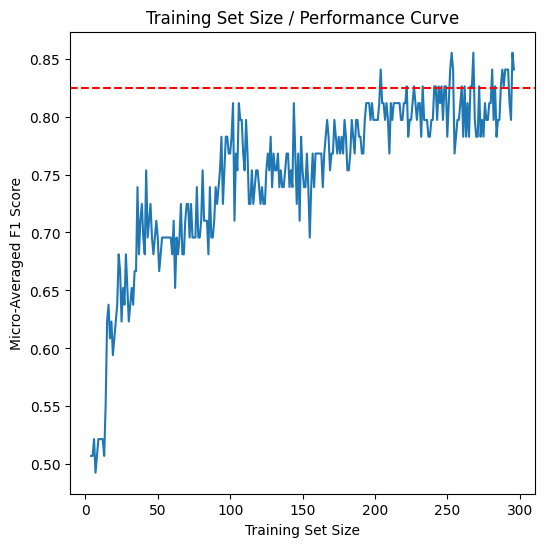

In [346]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(training_set_size_list, performance_list)
plt.xlabel("Training Set Size")
plt.ylabel("Micro-Averaged F1 Score")
plt.title("Training Set Size / Performance Curve")
plt.axhline(y = 0.825, xmin=0, xmax=1, color = "red", ls="--")
plt.show()
fig.savefig("trainingset_performance_curve.png")

In [347]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_TFIDF():
    def __init__(self, preprocess=True):
        # self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        # new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            # new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            # new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_ngram_data, num_chars, avg_length, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            # self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            # self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            # self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            # self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [348]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_TFIDF(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")
print(micro_f1_score_ensemble)

0.782608695652174


In [349]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_Ngrams():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        # self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        new_tfidf_data = None
        # new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            # new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            # new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_tfidf_data, num_chars, avg_length, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            # self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            # self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            # self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            # self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [350]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_Ngrams(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

print(micro_f1_score_ensemble)

0.7971014492753623


In [351]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_Word2Vec():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        # self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        # word_embeddings = None
        new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            # word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            # word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((new_tfidf_data, new_ngram_data, num_chars, avg_length, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            # self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            # self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    # def vectorize(self, sentence):
    #     words = sentence.split()
    #     words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
    #     if len(words_vecs) == 0:
    #         return np.zeros(100)
    #     words_vecs = np.array(words_vecs)
    #     return words_vecs.mean(axis=0)
        

In [352]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_Word2Vec(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

print(micro_f1_score_ensemble)

0.8260869565217391


In [353]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_POSTagging():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # # Parts of speech data
        # pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        # pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_tfidf_data, new_ngram_data, num_chars, avg_length))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    # def pos_tagger_func(self, row):
    #     fall_description = row["fall_description"]
    #     word_tokens = word_tokenize(fall_description)
    #     tagged_words = pos_tag(word_tokens)
    #     list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
    #     # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
    #     # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
    #     noun_count = 0
    #     pronoun_count = 0
    #     verb_count = 0
    #     adj_count = 0
    #     numeric_count = 0
        
    #     for tag in list_of_tags:
    #         if tag in ['NN','NNP','NNS']:
    #             noun_count += 1
    #         elif tag in ['PRP','PRP$']:
    #             pronoun_count += 1
    #         elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
    #             verb_count += 1
    #         elif tag in ['JJ','JJR','JJS']:
    #             adj_count += 1
    #         elif tag in ['CD']:
    #             numeric_count += 1
    #         # Not including else for other annotations because then it could throw the model training off track
    #     return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
    #                       adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
    #                      index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [355]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_POSTagging(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

print(micro_f1_score_ensemble)

0.8115942028985508


In [356]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_Number_Characters():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # # Number of characters data
        # input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        # num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # Average length of words data
        input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_tfidf_data, new_ngram_data, avg_length, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [357]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_Number_Characters(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

print(micro_f1_score_ensemble)

0.8260869565217391


In [358]:
# Making a custom "classifier" to handle data transformation... this is required so there is no train/test leakage through vectorized text
# This will be put through a scikit-learn pipeline, which allows it to be used correctly with a hyperparameter search and cross validation
class FreezingOfGaitDatasetBuilder_No_Avg_Length():
    def __init__(self, preprocess=True):
        self.tf_idf_vectorizer = None
        self.ngram_vectorizer = None
        self.word2vec_model = None
        self.preprocess = preprocess
    
    def transform(self, input_df, **transform_params):
        word_embeddings = None
        new_tfidf_data = None
        new_ngram_data = None
        
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
        
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df_new])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df_new.to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df_new.to_numpy()).toarray()

        else:
            # Word2Vec data
            word_embeddings = np.array([self.vectorize(sentence) for sentence in input_df["fall_description"]])
            
            # TF-IDF data
            new_tfidf_data = self.tf_idf_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()
    
            # N-gram data
            new_ngram_data = self.ngram_vectorizer.transform(input_df["fall_description"].to_numpy()).toarray()

        # Number of characters data
        input_df['num_characters'] = input_df.apply(lambda row : len(row["fall_description"]), axis = 1)
        num_chars = input_df['num_characters'].to_numpy().reshape(-1, 1)

        # # Average length of words data
        # input_df['avg_word_length'] = input_df.apply(lambda row: np.mean([len(word) for word in row["fall_description"].split()]), axis=1)
        # avg_length = input_df['avg_word_length'].to_numpy().reshape(-1, 1)

        # Parts of speech data
        pos_tag_counts = input_df.apply(lambda row: self.pos_tagger_func(row), axis = 1)
        pos_tag_array = pos_tag_counts[["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"]].to_numpy()
    
        pre_finalized_data = np.hstack((word_embeddings, new_tfidf_data, new_ngram_data, num_chars, pos_tag_array))
        standard_scaler = StandardScaler()
        finalized_data = standard_scaler.fit_transform(pre_finalized_data)
        return finalized_data
    
    def fit(self, input_df, y=None, **fit_params):
        sentences = None
        if self.preprocess == True:
            input_df_new = input_df["fall_description"].apply(self.preprocess_text_data)
            sentences = [sentence.split() for sentence in input_df_new]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df_new.to_numpy())
            self.ngram_vectorizer.fit(input_df_new.to_numpy())
        else:
            sentences = [sentence.split() for sentence in input_df["fall_description"]]
            self.word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=5)
            
            self.tf_idf_vectorizer = TfidfVectorizer()
            self.ngram_vectorizer = CountVectorizer(ngram_range=(1, 3))
            
            self.tf_idf_vectorizer.fit(input_df["fall_description"].to_numpy())
            self.ngram_vectorizer.fit(input_df["fall_description"].to_numpy())
        
        return self

    def fit_transform(self, input_df, y=None, **fit_transform_params):
        self.fit(input_df)
        return self.transform(input_df)

    def pos_tagger_func(self, row):
        fall_description = row["fall_description"]
        word_tokens = word_tokenize(fall_description)
        tagged_words = pos_tag(word_tokens)
        list_of_tags = [tag[1] for tag in tagged_words] # Just get list of tags
        # The POS tagger has a lot of possible tags, but since we don't want to increase dimensionality too much, we will condense this a bit
        # Inspiration taken from https://betterprogramming.pub/beginners-to-advanced-feature-engineering-from-text-data-c228047a4813
        noun_count = 0
        pronoun_count = 0
        verb_count = 0
        adj_count = 0
        numeric_count = 0
        
        for tag in list_of_tags:
            if tag in ['NN','NNP','NNS']:
                noun_count += 1
            elif tag in ['PRP','PRP$']:
                pronoun_count += 1
            elif tag in ['VB','VBD','VBG','VBN','VBP','VBZ']:
                verb_count += 1
            elif tag in ['JJ','JJR','JJS']:
                adj_count += 1
            elif tag in ['CD']:
                numeric_count += 1
            # Not including else for other annotations because then it could throw the model training off track
        return pd.Series([noun_count / len(list_of_tags), pronoun_count / len(list_of_tags), verb_count / len(list_of_tags), 
                          adj_count / len(list_of_tags), numeric_count / len(list_of_tags)], 
                         index=["Nouns", "Pronouns", "Verbs", "Adjectives", "Numerics"])

    def preprocess_text_data(self, text):
        stop_words = set(stopwords.words("english"))
        text = text.lower()
        text = ''.join([word for word in text if word not in string.punctuation])
        tokens = word_tokenize(text)
        tokens = [word for word in tokens if word not in stop_words]
        return ' '.join(tokens)

    def vectorize(self, sentence):
        words = sentence.split()
        words_vecs = [self.word2vec_model.wv[word] for word in words if word in self.word2vec_model.wv]
        if len(words_vecs) == 0:
            return np.zeros(100)
        words_vecs = np.array(words_vecs)
        return words_vecs.mean(axis=0)
        

In [359]:
ensemble_classifier = VotingClassifier(estimators=[
    ("nb", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), GaussianNB())),
    ("mlp", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), MLPClassifier(alpha=0.0001, learning_rate="adaptive", learning_rate_init=0.001, max_iter=4000, random_state=3))),
    ("knn", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), KNeighborsClassifier(n_neighbors=3, weights='uniform'))),
    ("svc", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), SVC(C=10, kernel="sigmoid", probability=True, random_state=3))),
    ("rf", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt', n_estimators=150, random_state=3))),
    ("lr", make_pipeline(FreezingOfGaitDatasetBuilder_No_Avg_Length(preprocess=False), LogisticRegression(C=0.01, max_iter=5000, penalty='l2', solver='saga', random_state=3)))
    ], voting='soft')

ensemble_classifier.fit(train_data, y_train)

y_pred = ensemble_classifier.predict(test_data)

micro_f1_score_ensemble = f1_score(y_test, y_pred, average="micro")

print(micro_f1_score_ensemble)

0.8115942028985508
